In [70]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col, length, regexp_replace
from pyspark.sql.types import IntegerType, BooleanType, StringType
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, PCA, VarianceThresholdSelector
from pyspark.ml.classification import RandomForestClassifier, LinearSVC, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation

from concurrent.futures import ThreadPoolExecutor

In [71]:
import numpy as np
import pandas as pd

# Graphics Libs
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 18, 8
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Initialising the spark session

In [72]:
spark = SparkSession.builder.appName('URLs_mining').getOrCreate()
spark

Show the original malicious_urls dataset

In [73]:
# Read the CSV file into a DataFrame
data = spark.read.csv("malicious_urls.csv", header=True, inferSchema=True)

# Show the first few rows of the DataFrame
data.show()

+--------------------+----------+
|                 url|      type|
+--------------------+----------+
|    br-icloud.com.br|  phishing|
|mp3raid.com/music...|    benign|
|bopsecrets.org/re...|    benign|
|http://www.garage...|defacement|
|http://adventure-...|defacement|
|http://buzzfil.ne...|    benign|
|espn.go.com/nba/p...|    benign|
|yourbittorrent.co...|    benign|
|http://www.pashmi...|defacement|
|allmusic.com/albu...|    benign|
|corporationwiki.c...|    benign|
|http://www.ikenmi...|defacement|
|myspace.com/video...|    benign|
|http://www.lebens...|defacement|
|http://www.szabad...|defacement|
|http://larcadelca...|defacement|
|quickfacts.census...|    benign|
|nugget.ca/Article...|    benign|
|uk.linkedin.com/p...|    benign|
|http://www.vnic.c...|defacement|
+--------------------+----------+
only showing top 20 rows



Count of every type of URL in the dataset

In [74]:
data.groupBy("type").count().show()

+--------------------+------+
|                type| count|
+--------------------+------+
|              benign|428103|
|          defacement| 96457|
|            phishing| 94108|
|             malware| 32520|
|                NULL|    15|
|                Ð|     1|
|PhµW\v;XyOy...|     1|
|cÔ¡æ>1\bHÇÕd...|     1|
|                spam| 12000|
+--------------------+------+



## Data pre-processing

Drop duplicates and count of every type of URL in the dataset

In [75]:
data = data.dropDuplicates(["url"])
data = data.na.drop()

data.groupBy("type").count().show()

+--------------------+------+
|                type| count|
+--------------------+------+
|                spam| 11921|
|              benign|428080|
|          defacement| 95308|
|            phishing| 94083|
|             malware| 23645|
|                Ð|     1|
|PhµW\v;XyOy...|     1|
|cÔ¡æ>1\bHÇÕd...|     1|
+--------------------+------+



Removing URLs whose type is not in ASCII

In [76]:
data = data.filter(col("type").rlike(r'^[ -~]+$'))
data.groupBy("type").count().show()

+----------+------+
|      type| count|
+----------+------+
|      spam| 11921|
|    benign|428080|
|defacement| 95308|
|  phishing| 94083|
|   malware| 23645|
+----------+------+



In [77]:
# convert spark dataframe to pandas dataframe
pd_data = data.toPandas()

Visualisation in a bar graph of the various URL types in the dataset

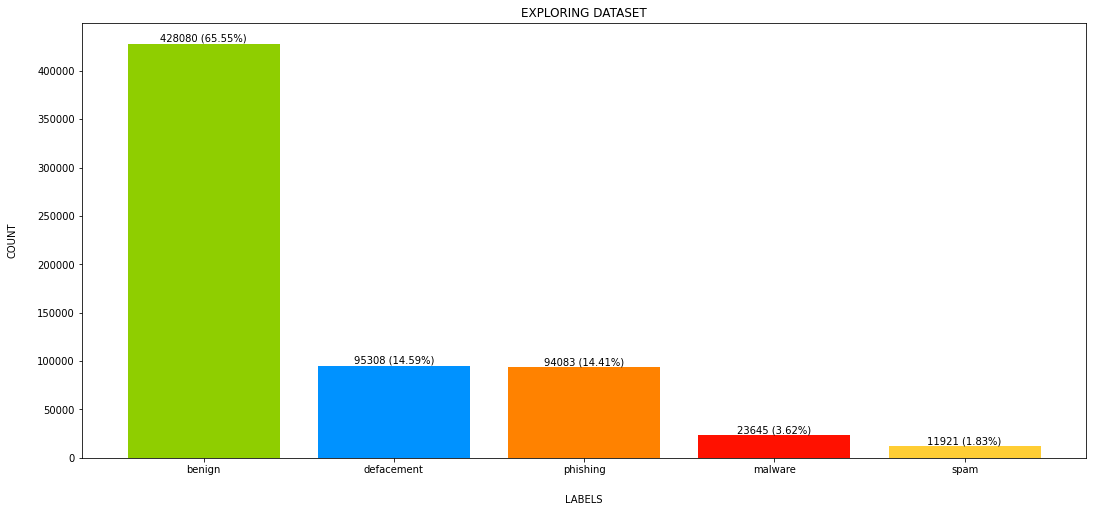

In [78]:
count = pd_data.type.value_counts()
bar_labels = [count.index[i].capitalize()+' (n. ' + str(count[i]) + ')' for i in range(len(count.index))]
bars = plt.bar(count.index, height=count, label=bar_labels, color=['#8fce00', '#0092ff', '#ff8200', '#ff1100', '#ffcd34'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(pd_data)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('LABELS', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING DATASET')
plt.show()

I make a mapping: benign urls become type 0 while the other types of urls i.e. defacement, phishing, malware, spam become type 1

In [79]:
data = data.withColumn("url_type", when(data["type"].contains("benign"), 0).otherwise(1))
#data = data.drop("type")
data.show()

+--------------------+--------+--------+
|                 url|    type|url_type|
+--------------------+--------+--------+
|   H\vÖË]t¹[ÈöýE|phishing|       1|
|^oð]Â|¬|hõElò...|phishing|       1|
|"½<+U½¹1\f[...|phishing|       1|
|"äÕ3ñºT-\fTÖGÑîÊ...|phishing|       1|
|"ëËl×uÏB'JI¨GÙn"...|phishing|       1|
|'118bm.com/images...|  benign|       0|
|'1pcables-inox.co...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
+--------------------+--------+--------+
only showing top

Selecting URLs that contain only ASCII characters

In [80]:
data = data.filter(col("url").rlike(r'^[ -~]+$'))
data.show()

+--------------------+------+--------+
|                 url|  type|url_type|
+--------------------+------+--------+
|'118bm.com/images...|benign|       0|
|'1pcables-inox.co...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
+--------------------+------+--------+
only showing top 20 rows



Making a count of selected URLs

In [81]:
data.groupBy("url_type").count().show()

+--------+------+
|url_type| count|
+--------+------+
|       1|224323|
|       0|427801|
+--------+------+



Visualisation in a bar graph of the two URL types in the dataset

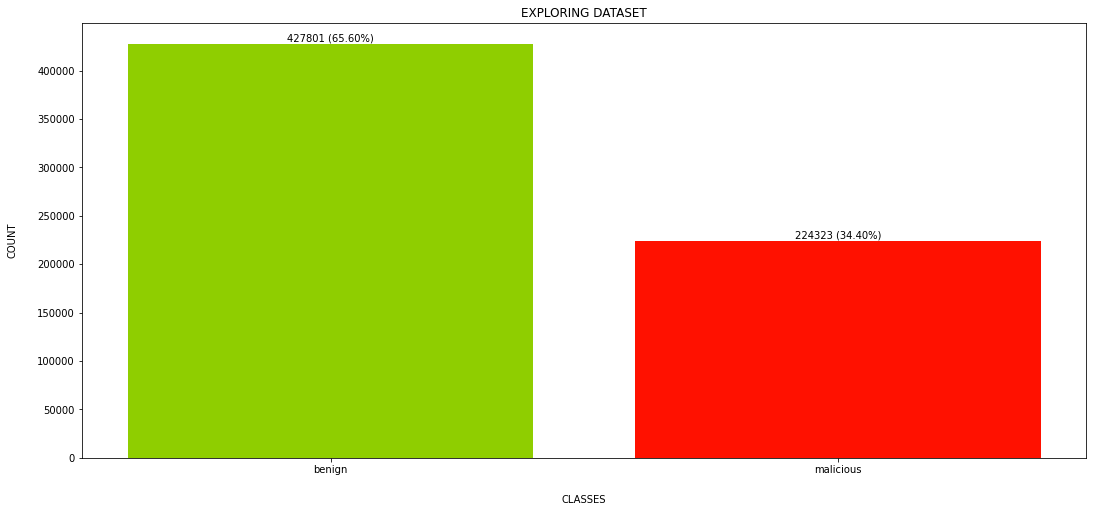

In [82]:
pd_data = data.toPandas()
count = pd_data.type.value_counts()

benign = count[0]
malicious = len(pd_data) - benign
bar_labels = ['Benign (n.'+str(benign)+')', 'Malicious (n.'+str(malicious)+')']
bars = plt.bar(['benign', 'malicious'], height=[benign, malicious], label=bar_labels, color=['#8fce00', '#ff1100'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(pd_data)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('CLASSES', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING DATASET')
plt.show()

Making a sample of 100.000 URLs for each type of URL

In [83]:
sample_size = 100000

data = data.sampleBy("url_type", fractions={0 : sample_size/data.filter(col("url_type") == 0).count(),
                                               1 : sample_size/data.filter(col("url_type") == 1).count()}, seed=42)
data.groupBy("url_type").count().show()

+--------+------+
|url_type| count|
+--------+------+
|       1|100473|
|       0|100153|
+--------+------+



Visualization in a bar chart of sampling

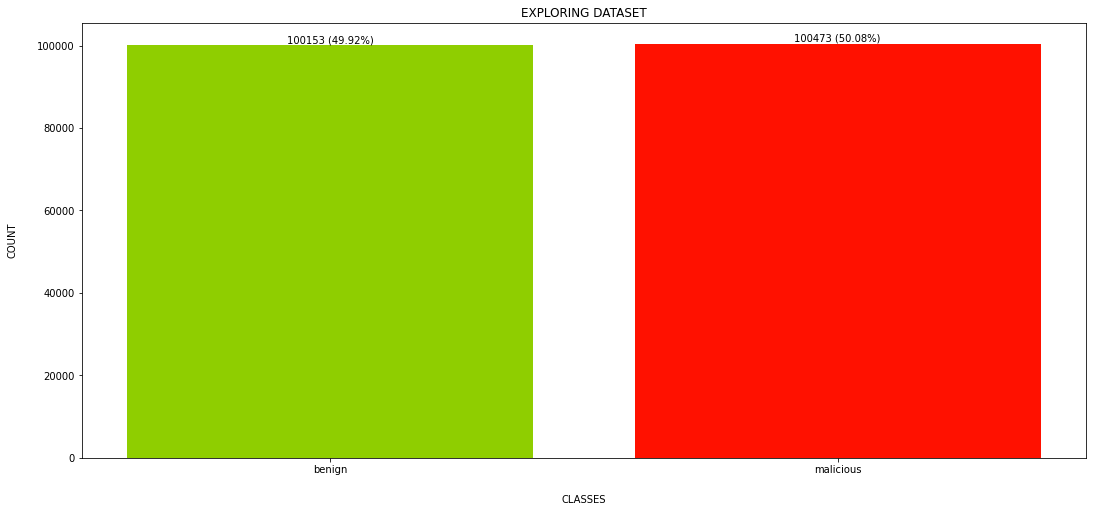

In [84]:
pd_data = data.toPandas()
count = pd_data.type.value_counts()

benign = count[0]
malicious = len(pd_data) - benign
bar_labels = ['Benign (n.'+str(benign)+')', 'Malicious (n.'+str(malicious)+')']
bars = plt.bar(['benign', 'malicious'], height=[benign, malicious], label=bar_labels, color=['#8fce00', '#ff1100'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(pd_data)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('CLASSES', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING DATASET')
plt.show()

## Features engineering

Starting from filtered and sampled URLs in the previous phase, in this phase there is the extraction of features like:
- "url_length" : lenght of URL
- "digit_count": number of digit characters in the URL
- "ampersand_count": number of ampersand characters in the URL
- "dot_count": number of dot characters in the URL
- "percent_count": number of '%' characters in the URL
- "at_count": number of '@' characters in the URL
- "tilde_count": number of '~' characters in the URL
- "hash_count": number of '#' characters in the URL
- "has_https": checks if the URL starts with 'https'
- "has_http": checks if the URL starts with 'http'
- "starts_with_digit": checks if the URL starts with a digit 

In [85]:
data = data.withColumn("url_length", length("url"))
data = data.withColumn("digit_count", length(regexp_replace(col("url"), "[^0-9]", "")))
data = data.withColumn("ampersand_count", length(regexp_replace(col("url"), "[^&]", "")))
data = data.withColumn("underscore_count", length(regexp_replace(col("url"), "[^_]", "")))
data = data.withColumn("dot_count", length(regexp_replace(col("url"), "[^.]", "")))
data = data.withColumn("percent_count", length(regexp_replace(col("url"), "[^%]", "")))
data = data.withColumn("at_count", length(regexp_replace(col("url"), "[^@]", "")))
data = data.withColumn("tilde_count", length(regexp_replace(col("url"), "[^~]", "")))
data = data.withColumn("hash_count", length(regexp_replace(col("url"), "[^#]", "")))
data = data.withColumn("has_https", when(data["url"].startswith("https"), 1).otherwise(0))
data = data.withColumn("has_http", when(data["url"].startswith("http"), 1).otherwise(0))
data = data.withColumn("starts_with_digit", when(data["url"].rlike("^[0-9]"), 1).otherwise(0))

In [86]:
data.show()

+--------------------+------+--------+----------+-----------+---------------+----------------+---------+-------------+--------+-----------+----------+---------+--------+-----------------+
|                 url|  type|url_type|url_length|digit_count|ampersand_count|underscore_count|dot_count|percent_count|at_count|tilde_count|hash_count|has_https|has_http|starts_with_digit|
+--------------------+------+--------+----------+-----------+---------------+----------------+---------+-------------+--------+-----------+----------+---------+--------+-----------------+
|'9d345009-a-62cb3...|benign|       0|       363|         46|              2|               1|        3|            3|       0|          0|         0|        0|       0|                0|
|'9d345009-a-62cb3...|benign|       0|       371|         51|              2|               6|        3|            3|       0|          0|         0|        0|       0|                0|
|'9d345009-a-62cb3...|benign|       0|       371|         50

Visualization of the distribution of values for each continuos numerical feature

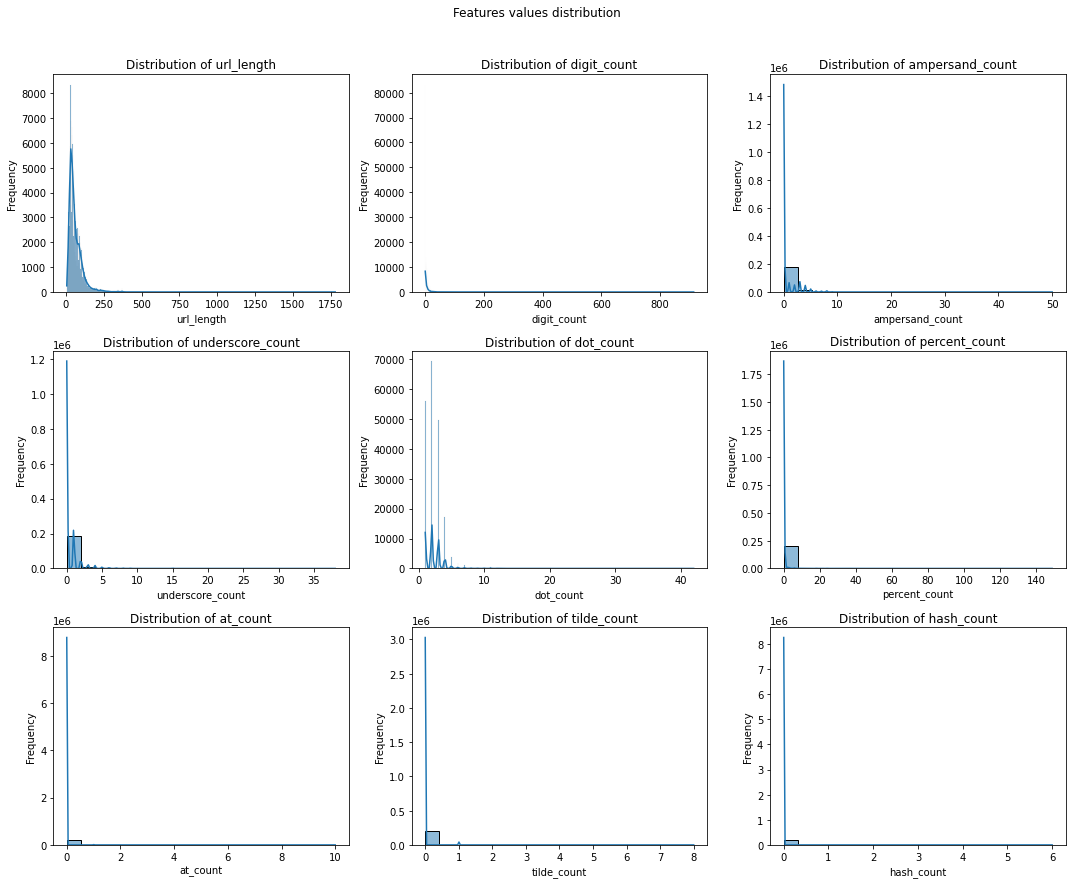

In [87]:
columns_to_check = ["url_length", "digit_count", "ampersand_count", "underscore_count", 
                    "dot_count", "percent_count", "at_count", "tilde_count", "hash_count"]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.suptitle("Features values distribution", y=1.02)

for i, col_name in enumerate(columns_to_check):
    row, col = divmod(i, 3)
    sns.histplot(data.select(col_name).toPandas()[col_name], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f"Distribution of {col_name}")
    axes[row, col].set_xlabel(col_name)
    axes[row, col].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Features selection

Dropping column type which contains strings

In [88]:
data = data.drop("type")
data.columns

['url',
 'url_type',
 'url_length',
 'digit_count',
 'ampersand_count',
 'underscore_count',
 'dot_count',
 'percent_count',
 'at_count',
 'tilde_count',
 'hash_count',
 'has_https',
 'has_http',
 'starts_with_digit']

Putting in a list all the features to be joined in a vector using VectorAssembler

In [89]:
feature_columns = [
    "url_length",
    "digit_count",
    "ampersand_count",
    "underscore_count",
    "dot_count",
    "percent_count",
    "at_count",
    "tilde_count",
    "hash_count",
    "has_https",
    "has_http",
    "starts_with_digit"
]
len(feature_columns)

12

In [90]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_vector")
data = assembler.transform(data)

In [91]:
data.select("features_vector").show(truncate=False)

+-----------------------------------------------+
|features_vector                                |
+-----------------------------------------------+
|(12,[0,1,2,3,4,5],[363.0,46.0,2.0,1.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,51.0,2.0,6.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,50.0,2.0,2.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,55.0,2.0,5.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,44.0,2.0,1.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,54.0,2.0,1.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,46.0,2.0,5.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,56.0,2.0,4.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,54.0,2.0,3.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,51.0,2.0,2.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,36.0,2.0,4.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,53.0,2.0,1.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,50.0,2.0,5.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,57.0,2.0,1.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,44.0,2.0,7.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,50.0,2.0,1.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,50.0,2.0,5.0,3.0,3.0])|


#### Variable associations

I visualise in a confusion matrix the associations between the various features extracted from the URLs

In [92]:
correlation_matrix = Correlation.corr(data, "features_vector").collect()[0][0]

correlation_df = pd.DataFrame(correlation_matrix.toArray(), columns=feature_columns, index=feature_columns)
correlation_df

,url_length,digit_count,ampersand_count,underscore_count,dot_count,percent_count,at_count,tilde_count,hash_count,has_https,has_http,starts_with_digit
url_length,1.000000,0.724601,0.450433,0.267642,0.341848,0.238022,0.042415,-0.026116,0.023422,0.055454,0.361881,-0.023899
digit_count,0.724601,1.000000,0.167507,0.156178,0.286452,0.370617,0.024203,-0.025226,0.023859,0.090717,0.188893,0.005650
ampersand_count,0.450433,0.167507,1.000000,0.272809,0.201634,-0.003051,0.006130,-0.037046,0.004576,-0.025841,0.373920,-0.023982
underscore_count,0.267642,0.156178,0.272809,1.000000,0.052066,0.004223,0.003350,-0.020067,0.001338,-0.015781,0.052333,-0.007819
dot_count,0.341848,0.286452,0.201634,0.052066,1.000000,-0.027341,0.044252,0.078825,0.037249,0.000129,0.276661,-0.037288
percent_count,0.238022,0.370617,-0.003051,0.004223,-0.027341,1.000000,0.004713,-0.009180,0.005251,0.030215,0.087664,-0.007005
at_count,0.042415,0.024203,0.006130,0.003350,0.044252,0.004713,1.000000,-0.002579,0.142870,0.090446,0.031655,-0.002619
tilde_count,-0.026116,-0.025226,-0.037046,-0.020067,0.078825,-0.009180,-0.002579,1.000000,0.006521,-0.017951,-0.079255,-0.008299
hash_count,0.023422,0.023859,0.004576,0.001338,0.037249,0.005251,0.142870,0.006521,1.000000,0.065866,0.007045,-0.002460
has_https,0.055454,0.090717,-0.025841,-0.015781,0.000129,0.030215,0.090446,-0.017951,0.065866,1.000000,0.231920,-0.015262


Plotting the confusion matrix

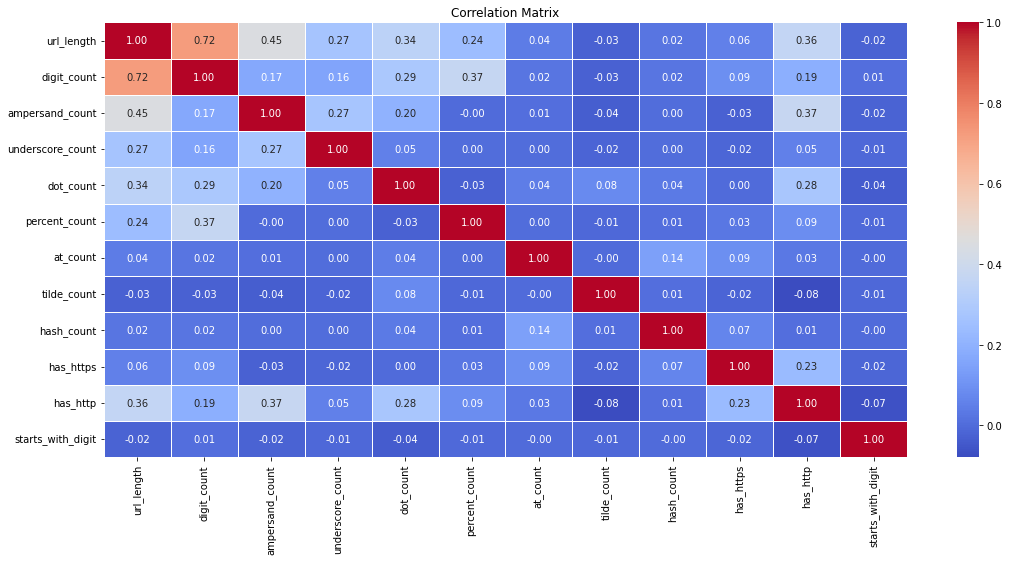

In [93]:
correlation_df.index, correlation_df.columns = feature_columns, feature_columns

sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

Displaying the five most related pairs of features

In [94]:
top_n = 6
correlation_pairs = set()

for col1 in correlation_df.columns:
    for col2 in correlation_df.columns:
        if col1 != col2:
            correlation_value = correlation_df.loc[col1, col2]
            pair = (col1, col2) if col1 < col2 else (col2, col1)
            correlation_pairs.add((pair, abs(correlation_value)))

correlation_pairs_list = list(correlation_pairs)
correlation_pairs_list.sort(key=lambda x: x[1], reverse=True)

correlation_pairs_list

[(('digit_count', 'url_length'), 0.724600672395066),
 (('ampersand_count', 'url_length'), 0.4504331203714154),
 (('ampersand_count', 'has_http'), 0.3739195103300492),
 (('digit_count', 'percent_count'), 0.3706169701556114),
 (('has_http', 'url_length'), 0.36188125662743087),
 (('dot_count', 'url_length'), 0.3418481620397599),
 (('digit_count', 'dot_count'), 0.286452159454512),
 (('dot_count', 'has_http'), 0.27666067767985025),
 (('ampersand_count', 'underscore_count'), 0.2728094157514348),
 (('underscore_count', 'url_length'), 0.2676415590939119),
 (('percent_count', 'url_length'), 0.2380218796916543),
 (('has_http', 'has_https'), 0.23191959453922747),
 (('ampersand_count', 'dot_count'), 0.2016340112947331),
 (('digit_count', 'has_http'), 0.18889253940039438),
 (('ampersand_count', 'digit_count'), 0.16750723187655833),
 (('digit_count', 'underscore_count'), 0.15617803473465136),
 (('at_count', 'hash_count'), 0.1428703613035425),
 (('digit_count', 'has_https'), 0.09071666621816121),
 ((

Selection of feature pairs whose correlation is greater than the set threshold

In [95]:
threshold_correlation = 0.35

threshold_features_set_list = [
    feature_pair[0] for feature_pair in correlation_pairs_list
    if feature_pair[1] > threshold_correlation
]

threshold_features_set_list

[('digit_count', 'url_length'),
 ('ampersand_count', 'url_length'),
 ('ampersand_count', 'has_http'),
 ('digit_count', 'percent_count'),
 ('has_http', 'url_length')]

Listing of individual features in selected pairs

In [96]:
threshold_features = []

for set_features in threshold_features_set_list:
    for feature in set_features:
        if feature not in threshold_features:
            threshold_features.append(feature)

threshold_features

['digit_count', 'url_length', 'ampersand_count', 'has_http', 'percent_count']

Assembling in a features vector to train models

In [97]:
assembler = VectorAssembler(inputCols=threshold_features, outputCol="threshold_features_vector")
data = assembler.transform(data)

In [98]:
data.select("threshold_features_vector").show(truncate=False)

+-------------------------+
|threshold_features_vector|
+-------------------------+
|[46.0,363.0,2.0,0.0,3.0] |
|[51.0,371.0,2.0,0.0,3.0] |
|[50.0,371.0,2.0,0.0,3.0] |
|[55.0,371.0,2.0,0.0,3.0] |
|[44.0,371.0,2.0,0.0,3.0] |
|[54.0,371.0,2.0,0.0,3.0] |
|[46.0,371.0,2.0,0.0,3.0] |
|[56.0,371.0,2.0,0.0,3.0] |
|[54.0,371.0,2.0,0.0,3.0] |
|[51.0,371.0,2.0,0.0,3.0] |
|[36.0,371.0,2.0,0.0,3.0] |
|[53.0,371.0,2.0,0.0,3.0] |
|[50.0,371.0,2.0,0.0,3.0] |
|[57.0,371.0,2.0,0.0,3.0] |
|[44.0,371.0,2.0,0.0,3.0] |
|[50.0,371.0,2.0,0.0,3.0] |
|[50.0,371.0,2.0,0.0,3.0] |
|[44.0,371.0,2.0,0.0,3.0] |
|[56.0,371.0,2.0,0.0,3.0] |
|[49.0,363.0,2.0,0.0,3.0] |
+-------------------------+
only showing top 20 rows



#### Variance Threshold Selector

The VarianceThresholdSelector is a feature selection technique in machine learning used to eliminate features with low variance. Variance measures the spread of values within a feature, the selector calculates the variance for each feature and removes those with values below a specified threshold. This technique is useful for discarding features with limited variability, thereby simplifying the model and reducing overfitting. 

In [99]:
selector = VarianceThresholdSelector(featuresCol="features_vector", varianceThreshold=1.0, outputCol="vts_features")
data = selector.fit(data).transform(data)

In [100]:
data.select("vts_features").show(truncate=False)

+----------------------------------------------+
|vts_features                                  |
+----------------------------------------------+
|(6,[0,1,2,3,4,5],[363.0,46.0,2.0,1.0,3.0,3.0])|
|(6,[0,1,2,3,4,5],[371.0,51.0,2.0,6.0,3.0,3.0])|
|(6,[0,1,2,3,4,5],[371.0,50.0,2.0,2.0,3.0,3.0])|
|(6,[0,1,2,3,4,5],[371.0,55.0,2.0,5.0,3.0,3.0])|
|(6,[0,1,2,3,4,5],[371.0,44.0,2.0,1.0,3.0,3.0])|
|(6,[0,1,2,3,4,5],[371.0,54.0,2.0,1.0,3.0,3.0])|
|(6,[0,1,2,3,4,5],[371.0,46.0,2.0,5.0,3.0,3.0])|
|(6,[0,1,2,3,4,5],[371.0,56.0,2.0,4.0,3.0,3.0])|
|(6,[0,1,2,3,4,5],[371.0,54.0,2.0,3.0,3.0,3.0])|
|(6,[0,1,2,3,4,5],[371.0,51.0,2.0,2.0,3.0,3.0])|
|(6,[0,1,2,3,4,5],[371.0,36.0,2.0,4.0,3.0,3.0])|
|(6,[0,1,2,3,4,5],[371.0,53.0,2.0,1.0,3.0,3.0])|
|(6,[0,1,2,3,4,5],[371.0,50.0,2.0,5.0,3.0,3.0])|
|(6,[0,1,2,3,4,5],[371.0,57.0,2.0,1.0,3.0,3.0])|
|(6,[0,1,2,3,4,5],[371.0,44.0,2.0,7.0,3.0,3.0])|
|(6,[0,1,2,3,4,5],[371.0,50.0,2.0,1.0,3.0,3.0])|
|(6,[0,1,2,3,4,5],[371.0,50.0,2.0,5.0,3.0,3.0])|
|(6,[0,1,2,3,4,5],[3

#### Principal Component Analysis - PCA

Principal Component Analysis (PCA) is a dimensionality reduction technique used in data analysis and machine learning. Its goal is to project the original data into a lower-dimensional space while preserving as much variance as possible. PCA identifies the principal axes along which the data varies the most and uses them as new variables, known as principal components. 

In [101]:
pca_components = 5
pca = PCA(k=pca_components, inputCol="features_vector", outputCol="pca_features")
pca_model = pca.fit(data)

In [102]:
data = pca_model.transform(data)

In [103]:
data.select("pca_features").show(truncate=False)

+----------------------------------------------------------------------------------------------------+
|pca_features                                                                                        |
+----------------------------------------------------------------------------------------------------+
|[-365.5514081011776,16.372861887450437,-0.7296347493709843,1.0117430546372144,-2.971039453158078]   |
|[-374.3100822182446,12.910973704839162,-1.4922236394048216,1.3891475391665034,0.3251856560551555]   |
|[-374.11706863763965,13.846029007844402,-1.2740377139347574,1.1882550682248634,-2.3231067145497293] |
|[-374.9818467126416,9.00954223137149,-2.081013953506984,1.3805116551821723,-0.19688371387317574]    |
|[-373.09467339192315,19.674468826656682,-0.3490943916376752,1.0817668695321099,-3.174596608531919]  |
|[-374.7888331320366,9.944597534376722,-1.862828028036919,1.1796191842405332,-2.84517608447806]      |
|[-373.45710294653946,17.766426394423455,-0.7186536807476642,1.2924445719

## Classification models

### Train test split

Splitting the features dataset in 80% of training data and 20% of test data

In [104]:
train, test = data.randomSplit([0.8, 0.2], seed = 2018)

This function takes in input:
- A spark classifier
- The training set
- The test set

It fits the model in the training set and it test the model in test set, then it computes metrics like:
- Accuracy
- Precision
- Recall

This function is useful to paralleling the training phase of the selected models

In [105]:
def train_and_evaluate(classifier, train, test):
    print(f"Training of: {classifier.__class__.__name__}")

    evaluator = MulticlassClassificationEvaluator(labelCol="url_type", predictionCol="prediction", metricName="accuracy")

    pipeline = Pipeline(stages=[classifier])

    model = pipeline.fit(train)
    predictions = model.transform(test)

    accuracy = round(evaluator.evaluate(predictions), 3)

    evaluator.setMetricName("weightedPrecision")
    precision = round(evaluator.evaluate(predictions), 3)

    evaluator.setMetricName("weightedRecall")
    recall = round(evaluator.evaluate(predictions), 3)

    result = {
        "model": model,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall
    }

    # Stampa le metriche del modello
    print(f"Accuracy of {classifier.__class__.__name__}: {accuracy}")
    print(f"Precision of {classifier.__class__.__name__}: {precision}")
    print(f"Recall of {classifier.__class__.__name__}: {recall}\n")

    return classifier.__class__.__name__, result

This function takes in input the dictionay containing experiments results and returns the model name, the list of accuracies computed, the list of precisons and the list of recall. This function is useful to plot model metrics

In [106]:
def get_metrics_list(metrics_dict: dict):
    model_names = list(metrics_dict.keys())
    accuracy_values = [metrics_dict[model]['accuracy'] for model in model_names]
    precision_values = [metrics_dict[model]['precision'] for model in model_names]
    recall_values = [metrics_dict[model]['recall'] for model in model_names]
    
    return model_names, accuracy_values, precision_values, recall_values

Define bars colors

In [107]:
colors = ['red', 'yellow', 'orange', 'purple']

### Choosed models

Classifier models are taken from the pyspark.ml.classification library and are:
1. Random forest classifier: Random Forest is robust, handles non-linear data well, and is less prone to overfitting, making it suitable for a wide range of classification problems.

2. Logistic regression: Logistic Regression is easy to interpret, computationally efficient, and suitable when the relationship between features and output is approximately linear.

3. Linear Support Vector Classifier (LinearSVC): LinearSVC is effective for linearly separable data, providing robustness and superior performance compared to traditional linear models.

4. Gradient Boosted Trees (GBT) Classifier: GBT is powerful for complex and non-linear data, building sequential trees to capture intricate relationships between features and output.

### Models trained using base features

In [108]:
base_classifiers = [
    RandomForestClassifier(featuresCol='features_vector', labelCol='url_type'),
    LogisticRegression(featuresCol='features_vector', labelCol='url_type'),
    LinearSVC(featuresCol='features_vector', labelCol='url_type'),
    GBTClassifier(featuresCol='features_vector', labelCol='url_type')
]

base_classifiers_results = {}

In [109]:
with ThreadPoolExecutor() as executor:
    base_classifiers_results = dict(executor.map(lambda clf: train_and_evaluate(clf, train, test), base_classifiers))

Training of: RandomForestClassifier
Training of: LogisticRegression
Training of: LinearSVC
Training of: GBTClassifier
Accuracy of LogisticRegression: 0.796
Precision of LogisticRegression: 0.81
Recall of LogisticRegression: 0.796

Accuracy of RandomForestClassifier: 0.844
Precision of RandomForestClassifier: 0.852
Recall of RandomForestClassifier: 0.844

Accuracy of GBTClassifier: 0.864
Precision of GBTClassifier: 0.866
Recall of GBTClassifier: 0.864

Accuracy of LinearSVC: 0.808
Precision of LinearSVC: 0.823
Recall of LinearSVC: 0.808



In [110]:
model_names, accuracy_values, precision_values, recall_values = get_metrics_list(base_classifiers_results)

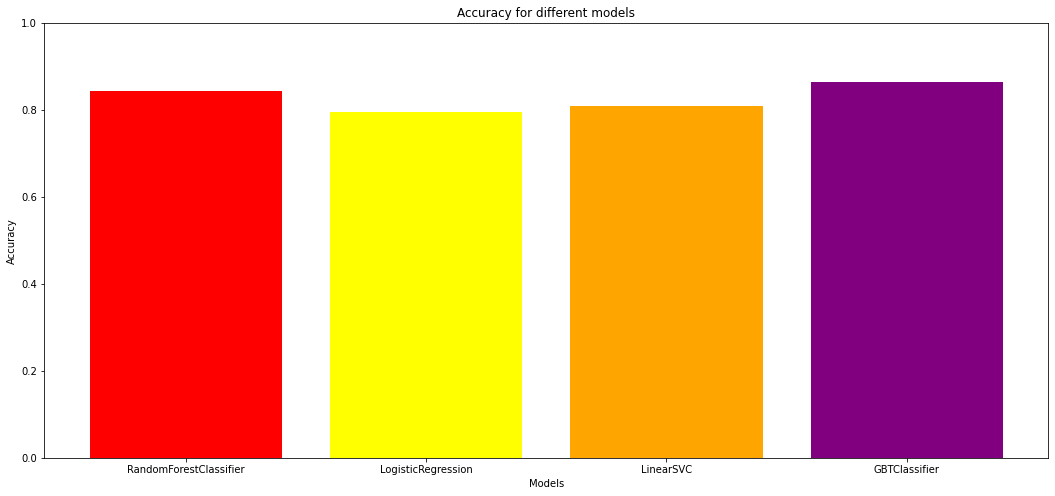

In [111]:
plt.bar(model_names, accuracy_values, color=colors)
plt.title('Accuracy for different models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()

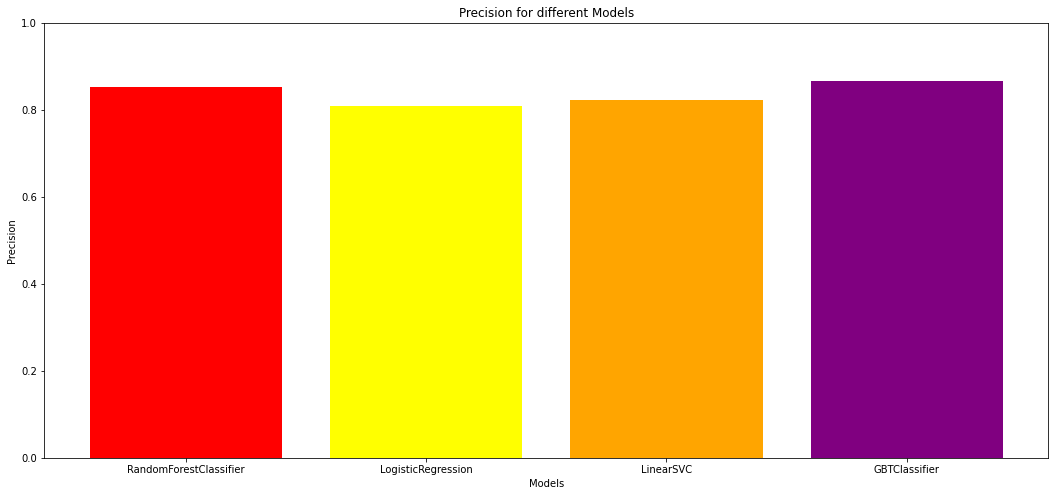

In [112]:
plt.bar(model_names, precision_values, color=colors)
plt.title('Precision for different Models')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.ylim([0, 1])
plt.show()

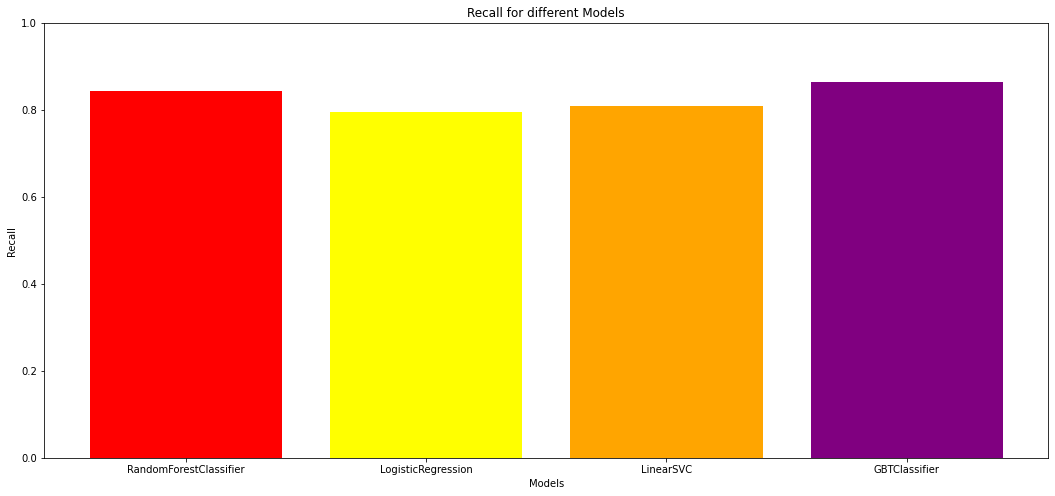

In [113]:
plt.bar(model_names, recall_values, color=colors)
plt.title('Recall for different Models')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.ylim([0, 1])
plt.show()

In [114]:
best_classifier = max(base_classifiers_results, key=lambda x: base_classifiers_results[x]['accuracy'])
best_classifier

'GBTClassifier'

#### Evaluation results using base features

| Model                  | Precision | Recall | Accuracy |
|------------------------|-----------|--------|----------|
| RandomForestClassifier | 0.855     | 0.846  | 0.846    |
| LogisticRegression     | 0.810     | 0.796  | 0.796    |
| LinearSVC              | 0.823     | 0.808  | 0.808    |
| <span style="color:green"> GBTClassifier </span>           | 0.864     | 0.863  | 0.863    |


### Models trained using PCA features

In [115]:
pca_classifiers = [
    RandomForestClassifier(featuresCol='pca_features', labelCol='url_type'),
    LogisticRegression(featuresCol='pca_features', labelCol='url_type'),
    LinearSVC(featuresCol='pca_features', labelCol='url_type'),
    GBTClassifier(featuresCol='pca_features', labelCol='url_type')
]

pca_classifiers_results = {}

In [116]:
with ThreadPoolExecutor() as executor:
    pca_classifiers_results = dict(executor.map(lambda clf: train_and_evaluate(clf, train, test), pca_classifiers))

Training of: RandomForestClassifier
Training of: LogisticRegression
Training of: LinearSVCTraining of: GBTClassifier

Accuracy of LogisticRegression: 0.719
Precision of LogisticRegression: 0.727
Recall of LogisticRegression: 0.719

Accuracy of RandomForestClassifier: 0.754
Precision of RandomForestClassifier: 0.754
Recall of RandomForestClassifier: 0.754

Accuracy of GBTClassifier: 0.79
Precision of GBTClassifier: 0.79
Recall of GBTClassifier: 0.79

Accuracy of LinearSVC: 0.746
Precision of LinearSVC: 0.751
Recall of LinearSVC: 0.746



In [117]:
model_names, accuracy_values, precision_values, recall_values = get_metrics_list(pca_classifiers_results)

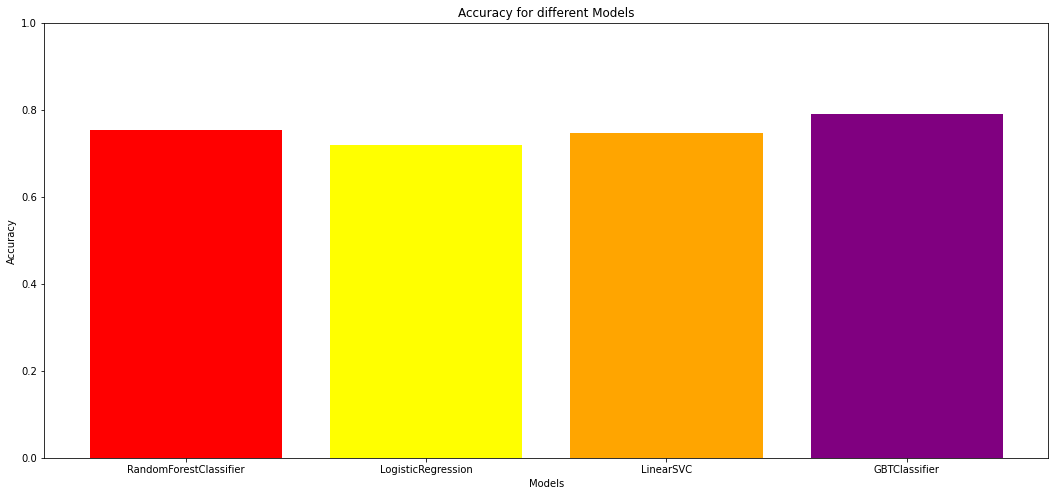

In [118]:
plt.bar(model_names, accuracy_values, color=colors)
plt.title('Accuracy for different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()

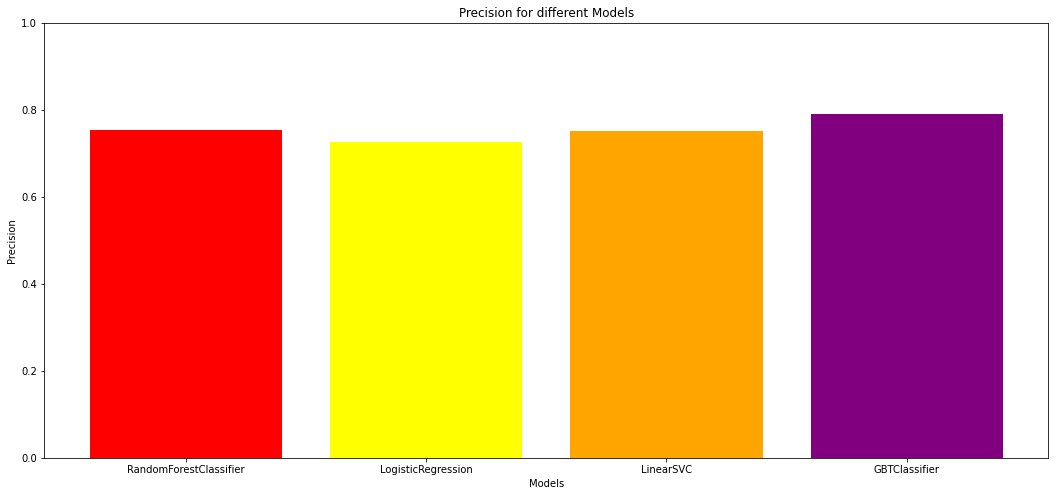

In [119]:
plt.bar(model_names, precision_values, color=colors)
plt.title('Precision for different Models')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.ylim([0, 1])
plt.show()

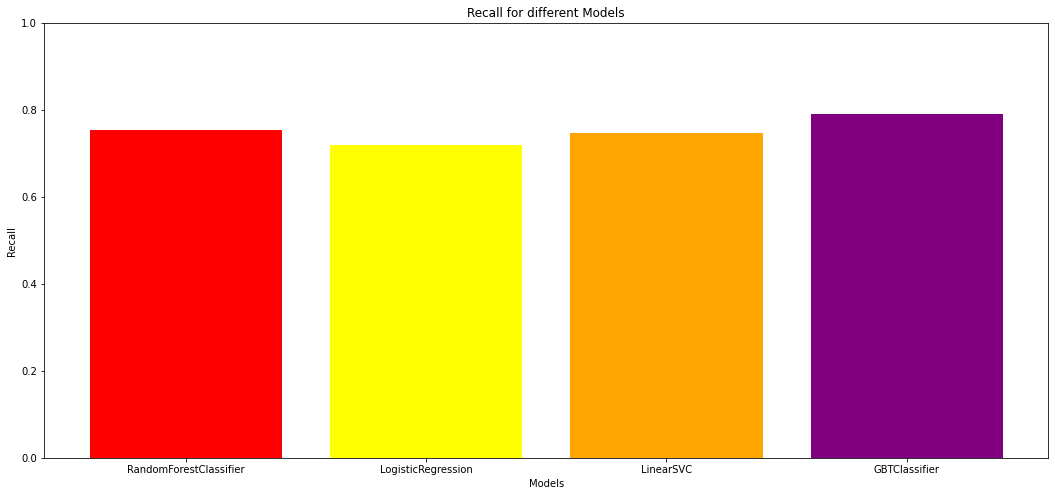

In [120]:
plt.bar(model_names, recall_values, color=colors)
plt.title('Recall for different Models')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.ylim([0, 1])
plt.show()

In [121]:
best_classifier_pca = max(pca_classifiers_results, key=lambda x: pca_classifiers_results[x]['accuracy'])
best_classifier_pca 

'GBTClassifier'

#### Evaluation results using PCA features

| Model                  | Accuracy | Precision | Recall |
|------------------------|----------|-----------|--------|
| LogisticRegression     | 0.719    | 0.727     | 0.719  |
| RandomForestClassifier | 0.753    | 0.753     | 0.753  |
| <span style="color:green"> GBTClassifier </span>           | 0.789    | 0.789     | 0.789  |
| LinearSVC              | 0.746    | 0.751     | 0.746  |

### Models trained using VTS features

In [122]:
vts_classifiers = [
    RandomForestClassifier(featuresCol='vts_features', labelCol='url_type'),
    LogisticRegression(featuresCol='vts_features', labelCol='url_type'),
    LinearSVC(featuresCol='vts_features', labelCol='url_type'),
    GBTClassifier(featuresCol='vts_features', labelCol='url_type')
]

vts_classifiers_results = {}

In [ ]:
with ThreadPoolExecutor() as executor:
    vts_classifiers_results = dict(executor.map(lambda clf: train_and_evaluate(clf, train, test), vts_classifiers))

Training of: RandomForestClassifier
Training of: LogisticRegression
Training of: LinearSVC
Training of: GBTClassifier


In [ ]:
model_names, accuracy_values, precision_values, recall_values = get_metrics_list(vts_classifiers_results)

In [ ]:
plt.bar(model_names, accuracy_values, color=colors)
plt.title('Accuracy for different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()

In [ ]:
plt.bar(model_names, precision_values, color=colors)
plt.title('Precision for different Models')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.ylim([0, 1])
plt.show()

In [ ]:
plt.bar(model_names, recall_values, color=colors)
plt.title('Recall for different Models')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.ylim([0, 1])
plt.show()

In [ ]:
best_classifier_vts = max(vts_classifiers_results, key=lambda x: vts_classifiers_results[x]['accuracy'])
best_classifier_vts 

#### Evaluation results using VTS features

| Model                  | Accuracy | Precision | Recall |
|------------------------|----------|-----------|--------|
| LogisticRegression     | 0.72     | 0.731     | 0.72   |
| RandomForestClassifier | 0.739    | 0.752     | 0.739  |
| <span style="color:green"> GBTClassifier </span>          | 0.762    | 0.763     | 0.762  |
| LinearSVC              | 0.725    | 0.735     | 0.725  |

### Models trained using threshold features

In [ ]:
threshold_classifiers = [
    RandomForestClassifier(featuresCol='threshold_features_vector', labelCol='url_type'),
    LogisticRegression(featuresCol='threshold_features_vector', labelCol='url_type'),
    LinearSVC(featuresCol='threshold_features_vector', labelCol='url_type'),
    GBTClassifier(featuresCol='threshold_features_vector', labelCol='url_type')
]

threshold_classifiers_results = {}

In [ ]:
with ThreadPoolExecutor() as executor:
    threshold_classifiers_results = dict(executor.map(lambda clf: train_and_evaluate(clf, train, test), threshold_classifiers))

In [ ]:
model_names, accuracy_values, precision_values, recall_values = get_metrics_list(vts_classifiers_results)

In [ ]:
plt.bar(model_names, accuracy_values, color=colors)
plt.title('Accuracy for different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()

In [ ]:
plt.bar(model_names, precision_values, color=colors)
plt.title('Precision for different Models')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.ylim([0, 1])
plt.show()

In [ ]:
plt.bar(model_names, recall_values, color=colors)
plt.title('Recall for different Models')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.ylim([0, 1])
plt.show()

In [ ]:
best_classifier_threshold = max(threshold_classifiers_results, key=lambda x: threshold_classifiers_results[x]['accuracy'])
best_classifier_threshold

| Model                 | Accuracy | Precision | Recall |
|-----------------------|----------|-----------|--------|
| Logistic Regression   | 0.798    | 0.818     | 0.798  |
| RandomForestClassifier| 0.806    | 0.826     | 0.806  |
| <span style="color:green"> GBTClassifier </span> | 0.825    | 0.84      | 0.825  |
| LinearSVC             | 0.804    | 0.823     | 0.804  |


## Summary base models

In all of the four cases taken into account:
- Training of base models with base features
- Training of base models with PCA features
- Training of base models with VTS features
- Training of base models with features after applying a threshold on feature importance

the Gradient Boosting Tree classifier was the best, here there are performances of each version:

| Model                  | Accuracy | Precision | Recall |
|------------------------|----------|-----------|--------|
| <span style="color:green"> GBTClassifier (base) </span>  | 0.864    | 0.863    | 0.863  |
| GBTClassifier (PCA)    | 0.789    | 0.789     | 0.789  |
| GBTClassifier (VTS)    | 0.762    | 0.763     | 0.762  |
| GBTClassifier (threshold)| 0.825    | 0.84      | 0.825  |

## Conclusions

In conclusion, we can say that the basic model trained with all features, without performing feature selection turns out to be the best of the models considered to which various feature selection techniques were applied. This rather unexpected result can be explained as follows: the extracted features, even the most teachable ones, contribute to the distinction between malicious and benign URLs.

In [ ]:
spark.stop()